### Created by Pablo Zurita Lozano
BMEN 351-501

Prof. Hanks

In [72]:
# importing modules and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from  tensorflow.keras import models, layers
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, roc_curve, auc, make_scorer, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from scipy.stats import chi2_contingency, f_oneway
from itertools import cycle
from graphviz import Digraph

### Preprocessing Data

In [74]:
# Create a new directed graph for the flowchart requirement
dot = Digraph(comment='Data Preprocessing Flow')
dot.graph_attr['size'] = '20,20!'  # Width,Height; ! means keep the size exact
dot.graph_attr['ratio'] = 'compress'  # Adjust aspect ratio to make the graph more compact
dot.graph_attr['label'] = 'Preprocessing Steps'  # Add a title
dot.graph_attr['labelloc'] = 't'  # Position the title at the top (t for top)
dot.graph_attr['fontsize'] = '20'  # Set title font size

# Define the nodes (steps)
dot.node('A', 'Load Data')
dot.node('B', 'Make Sure that Pandas is Handling Data Correctly')
dot.node('C', 'Calculate and Plot the Original Raw Data Baseline')
dot.node('D', 'Drop Columns with Only One Unique Value & Identifier Columns')
dot.node('E', 'Feature Engineering: Combining Visit Types to Total Visits Column')
dot.node('F', 'Check Columns for Missing/Confounding Data and Drop if Needed')
dot.node('G', 'Relabel Data by Mapping Using IDS')
dot.node('H', 'Drop All Medication/Medical Test Columns')
dot.node('J', 'Check Statistical Relevance on Remaining Columns')
dot.node('K', 'Chi-Square Test for Categorical vs. Categorical')
dot.node('L', 'One-way ANOVA Test for Categorical vs. Numerical')
dot.node('M', 'Do Final Cleaning of Dataset')
dot.node('N', 'Change Age Column to Mean of Range')
dot.node('O', 'Change Readmit Column to Number Labels')
dot.node('P', 'One-Hot Encode Other Categorical Columns')
dot.node('Q', 'Normalize Numerical Columns')
dot.node('R', 'Calculate and Plot Clean Dataset Baseline')
dot.node('V', 'Correlation Matrix')

# Define the edges (connections between steps)
dot.edges(['AB', 'BC', 'BD', 'DF', 'FG', 'GH', 'HJ', 'JK', 'JL', 'MN', 'MO', 'OP', 'NQ', 'MR', 'HM', 'HE', 'JV'])

# Render the flowchart to a file
dot.render('preprocessing_flowchart', format='png')  # Saves it as 'preprocessing_flowchart.png'

# View the flowchart (if needed)
dot.view()

'preprocessing_flowchart.pdf'

In [75]:
# Create a new directed graph for the flowchart requirement
dot2 = Digraph(comment='Final Models Flow')
dot2.graph_attr['size'] = '20,20!'  # Width,Height; ! means keep the size exact
dot2.graph_attr['ratio'] = 'compress'  # Adjust aspect ratio to make the graph more compact
dot2.graph_attr['label'] = 'Final Models Steps'  # Add a title
dot2.graph_attr['labelloc'] = 't'  # Position the title at the top (t for top)
dot2.graph_attr['fontsize'] = '20'  # Set title font size

dot2.node('a', 'Sequential Model and Random Forest Model Chosen')
dot2.node('b', 'Change Hyperparameters Until Baseline is Beaten')
dot2.node('c', 'Do all Calculations and Graphs')
dot2.node('d', 'Try Regularization Hyperparameters')
dot2.node('A', 'Determine if Augmentation Methods Help')
dot2.node('B', 'Add or Remove Augmentation Methods Based on Outcome')

dot2.edges(['ab', 'bc', 'bd', 'db', 'aA', 'AB'])

# Render the flowchart to a file
dot2.render('final_models_flowchart', format='png')  # Saves it as 'final_models_flowchart.png'

# View the flowchart (if needed)
dot2.view()

'final_models_flowchart.pdf'

In [76]:
# Reading in dataset as dataframe
df = pd.read_csv("C:\\Users\\pazul\\Documents\\BMEN 351\\Project 1\\diabetes+130-us+hospitals+for+years+1999-2008 (1)\\diabetic_data.csv")
# Avoiding pandas from setting the string 'None' to a NaN value
df[['max_glu_serum', 'A1Cresult']]=df[['max_glu_serum', 'A1Cresult']].replace(pd.NA, 'Not tested')
df2 = df
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


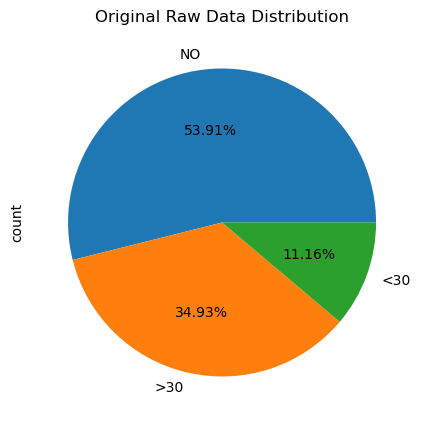

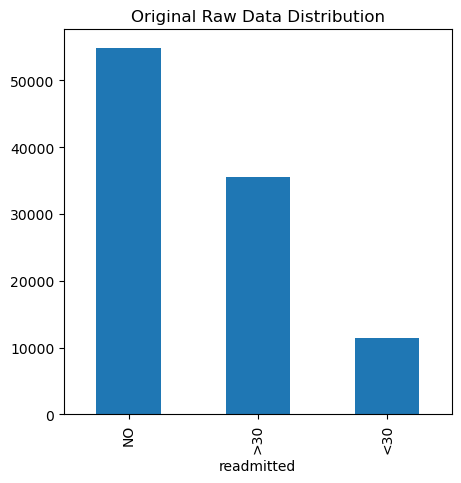

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64
readmitted
NO     53.911916
>30    34.928169
<30    11.159916
Name: count, dtype: float64

The baseline should be 53.911915571015854% for the original raw data.


In [77]:
#checking the original raw data baseline
value_counts = df['readmitted'].value_counts()
value_counts.plot(kind='pie',autopct='%.2f%%',figsize=(15,5))
plt.title('Original Raw Data Distribution')
plt.show()

value_counts.plot(kind='bar',figsize=(5,5))
plt.title('Original Raw Data Distribution')
plt.show()

print(value_counts)
percentages = (value_counts / len(df))* 100
print(percentages)
print(f"\nThe baseline should be {percentages['NO']}% for the original raw data.")

In [78]:
#drops columns with data only having one unique value and also id columns
unique_val = df.nunique()
fea_rmf = unique_val[unique_val==1].index
df.drop(columns=fea_rmf, inplace=True)
print(fea_rmf)

#dropping id columns
df.drop(columns=['encounter_id', 'patient_nbr'], inplace=True)

Index(['examide', 'citoglipton'], dtype='object')


In [79]:
race_value_counts = df['race'].value_counts()
print(race_value_counts)

race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64


In [80]:
print(df['gender'].value_counts())
df=df[df['gender']!='Unknown/Invalid']# 3 cases of uncollected data dropped

gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64


In [81]:
weight_percentages = df['weight'].value_counts(1)*100
print(weight_percentages)
df = df.drop(columns='weight') # Too many data points missing

weight
?            96.858387
[75-100)      1.312854
[50-75)       0.881460
[100-125)     0.614172
[125-150)     0.142488
[25-50)       0.095320
[0-25)        0.047168
[150-175)     0.034394
[175-200)     0.010809
>200          0.002948
Name: proportion, dtype: float64


In [82]:
#1:'Emergency',2:'Urgent',3:'Elective',4:'Newborn',5:'Not Available',6: 'NULL',7:'Trauma Center', 8:'Not Mapped'
#remapping to simplify
df['admission_type_id']=df['admission_type_id'].replace({1:'Emergency',2:'Emergency',3:'Elective',
                                                        4:'Newborn',5:'Not Available',6: 'Not Available',
                                                        7:'Emergency', 8:'Not Available'})

In [83]:
display(df[df['admission_type_id']== 'Newborn'][['age','admission_type_id']])
df=df[df['admission_type_id']!='Newborn'] # newborn is confounding

,age,admission_type_id
2043,[50-60),Newborn
2203,[80-90),Newborn
2461,[70-80),Newborn
4823,[60-70),Newborn
35877,[60-70),Newborn
47548,[40-50),Newborn
48711,[70-80),Newborn
80354,[0-10),Newborn
87714,[60-70),Newborn
100721,[80-90),Newborn


In [84]:
# patients who are dead, hospice, or neonates. Will not be readmitted
rows_to_remove_discharge = [10, 11, 13, 14, 19, 20, 21]
df_clean = df[~df['discharge_disposition_id'].isin(rows_to_remove_discharge)]

In [85]:
#Relabeling based on IDS mapping
df['admission_source_id']=df['admission_source_id'].replace({1:'Referral',2:'Referral',3:'Referral',
                                                             4:'Transferred',5:'Transferred',6:'Transferred',
                                                             7:'Emergency',8:'Emergency',9:'Not Available',
                                                             10:'Transferred',11:'Birth',12:'Birth',13:'Birth',
                                                             14:'Birth',15:'Not Given',17:'Not Given',
                                                             18:'Transferred',19:'Transferred',20:'Not Given',
                                                             21:'Not Given',22:'Transferred',23:'Birth',24:'Birth',
                                                             25:'Transferred',26:'Transferred'
                                                            })
df['admission_source_id'].value_counts()
display(df[df['admission_source_id']=='Birth'][['gender','age','admission_source_id']])
df=df[df['admission_source_id']!='Birth'] # contradictory data

,gender,age,admission_source_id
83432,Female,[70-80),Birth
83510,Female,[20-30),Birth
85588,Female,[70-80),Birth
97384,Male,[70-80),Birth


In [86]:
#Checking payer code distribution
payer_code_counts = df['payer_code'].value_counts(1)*100
print(payer_code_counts)
df = df.drop(columns='payer_code') #40% is missing and not particularly relevant

payer_code
?     39.558128
MC    31.880412
HM     6.166154
SP     4.920933
BC     4.574984
MD     3.470304
CP     2.485528
UN     2.404938
CM     1.899773
OG     1.015243
PO     0.581824
DM     0.539563
CH     0.143490
WC     0.132679
OT     0.093367
MP     0.077642
SI     0.054055
FR     0.000983
Name: proportion, dtype: float64


In [87]:
specialty_counts = df['medical_specialty'].value_counts(1)*100
print(specialty_counts) #49% is missing, but will keep due to relevance

medical_specialty
?                                49.077632
InternalMedicine                 14.381468
Emergency/Trauma                  7.434963
Family/GeneralPractice            7.311128
Cardiology                        5.259020
                                   ...    
SportsMedicine                    0.000983
Speech                            0.000983
Perinatology                      0.000983
Neurophysiology                   0.000983
Pediatrics-InfectiousDiseases     0.000983
Name: proportion, Length: 73, dtype: float64


In [88]:
#dropping other unwanted columns
#  'examide', 'citoglipton' dropped above
meds_and_tests_to_drop = [ 'A1Cresult','metformin','repaglinide', 'nateglinide', 'chlorpropamide',
                'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
                'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
                'tolazamide', 'glyburide-metformin', 'max_glu_serum',
                'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                'metformin-pioglitazone', 'insulin'
               ]

df = df.drop(meds_and_tests_to_drop, axis=1)
df = df.replace('?', pd.NA)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49731 entries, 9 to 101764
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      49731 non-null  object
 1   gender                    49731 non-null  object
 2   age                       49731 non-null  object
 3   admission_type_id         49731 non-null  object
 4   discharge_disposition_id  49731 non-null  int64 
 5   admission_source_id       49731 non-null  object
 6   time_in_hospital          49731 non-null  int64 
 7   medical_specialty         49731 non-null  object
 8   num_lab_procedures        49731 non-null  int64 
 9   num_procedures            49731 non-null  int64 
 10  num_medications           49731 non-null  int64 
 11  number_outpatient         49731 non-null  int64 
 12  number_emergency          49731 non-null  int64 
 13  number_inpatient          49731 non-null  int64 
 14  diag_1                    

In [89]:
# Map diagnosis codes to disease groups for later
diagnosis_mapping = {
    'Diseases of the Circulatory System': {str(i) for i in range(390, 460)}.union({'785'}),
    'Diseases of the Respiratory System': {str(i) for i in range(460, 520)}.union({'786'}),
    'Diseases of the Digestive System': {str(i) for i in range(520, 580)}.union({'787'}),
    'Diabetes Mellitus': {'250'},
    'Injury & Poisoning': {str(i) for i in range(800, 1000)},
    'Diseases of the Musculoskeletal System & Connective Tissue': {str(i) for i in range(710, 740)},
    'Diseases of the Genitourinary System': {str(i) for i in range(580, 630)}.union({'788'}),
    'Neoplasms': {str(i) for i in range(140, 240)},
    'Other Symptoms, Signs & Ill-defined Conditions': {str(i) for i in range(790, 800)}.union({'780', '781', '784'}),
    'Endocrine, Nutritional & Metabolic Diseases, & Immunity Disorders Without␣Diabetes': {str(i) for i in range(240, 280) if i != 250},
    'Diseases of the Skin & Subcutaneous Tissue': {str(i) for i in range(680,710)}.union({'782'}),
    'Infectious & Parasitic Diseases': {str(i) for i in range(1, 140)},
    'Mental Disorders': {str(i) for i in range(290, 320)},
    'Diseases of the Blood & Blood Forming Organs': {str(i) for i in range(280,290)},
    'Diseases of the Nervous System': {str(i) for i in range(320, 360)},
    'Complications of Pregnancy, Childbirth & the Puerperium': {str(i) for i in range(630, 680)},
    'Diseases of the Sense Organs': {str(i) for i in range(360, 390)},
    'Congenital Anomalies': {str(i) for i in range(740, 760)},
    'External Causes of Injury & Supplemental Classification': {'E'},
    'Supplementary Classification': {'V'}
    }
def map_diagnosis(code):
    if pd.isna(code):
        return 'Other'
    code_str = str(code).upper()
    for category, codes in diagnosis_mapping.items():
        if any(code_str.startswith(c) for c in codes):
            return category
    return 'Other'

diags = ['diag_1', 'diag_2', 'diag_3']
# Map diagnosis codes to descriptive labels
for col in diags:
    if col in df.columns:
        df[col] = df[col].apply(map_diagnosis)

display(df[diags])

,diag_1,diag_2,diag_3
9,Diseases of the Circulatory System,Neoplasms,Diseases of the Respiratory System
12,Diseases of the Circulatory System,Diabetes Mellitus,Diabetes Mellitus
13,Diseases of the Circulatory System,Diseases of the Circulatory System,Diseases of the Circulatory System
17,Diseases of the Skin & Subcutaneous Tissue,Neoplasms,Diabetes Mellitus
26,Diseases of the Circulatory System,Diseases of the Circulatory System,Diseases of the Circulatory System
...,...,...,...
101735,Diseases of the Digestive System,Diseases of the Digestive System,Diabetes Mellitus
101743,Diseases of the Respiratory System,"Endocrine, Nutritional & Metabolic Diseases, &...",Diseases of the Circulatory System
101747,Diseases of the Circulatory System,Infectious & Parasitic Diseases,Diabetes Mellitus
101749,Diseases of the Musculoskeletal System & Conne...,Diseases of the Circulatory System,Diabetes Mellitus


### Statistical Analysis

In [91]:
#Statistical Relevance Checking
# Set alpha for significance level
alpha = 0.05

# Prepare a list to hold the results
results = []

# Identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int', 'float']).columns.tolist()

# Chi-Square Test for categorical vs. categorical
for col in categorical_columns:
    if col != 'readmitted':  # Skip the target variable
        # Create a contingency table
        contingency_table = pd.crosstab(df[col], df['readmitted'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Check significance
        is_significant = p < alpha
        results.append({
            'Variable': col,
            'p-value': p,
            'Significant': is_significant
        })

# One-Way ANOVA for categorical vs. numerical
for col in numerical_columns:
    if col != 'readmitted':  # Skip the target variable
        # Group data by the 'readmitted' category
        groups = [group[col].values for name, group in df_clean.groupby('readmitted')]
        f_stat, p = f_oneway(*groups)
        
        # Check significance
        is_significant = p < alpha
        results.append({
            'Variable': col,
            'p-value': p,
            'Significant': is_significant
        })

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results)

# Display the results DataFrame
display(results_df)

,Variable,p-value,Significant
0,race,2.398272e-04,True
1,gender,6.711088e-04,True
2,age,3.122011e-18,True
3,admission_type_id,3.884420e-24,True
4,admission_source_id,5.634607e-99,True
5,medical_specialty,4.456364e-150,True
6,diag_1,8.195735e-60,True
7,diag_2,8.510212e-23,True
8,diag_3,6.543601e-23,True
9,change,3.128583e-36,True


### Feature Engineering

In [93]:
# combining the number of inpatient, outpatient, and inpatient may be a more useful format for ML
df['total_annual_visits'] = df['number_outpatient'] + df['number_inpatient'] + df['number_emergency']

df=df.drop(columns=['number_emergency', 'number_inpatient', 'number_outpatient'])

### Final Dataframe Cleaning

In [95]:
def clean_dataframe(df_1):
    def age_range_to_mean(age_range):
        if isinstance(age_range, str):
            lower_bound = int(age_range.split('-')[0][1:])
            upper_bound = int(age_range.split('-')[1][:-1])
            return (lower_bound + upper_bound) / 2
        else:
            return age_range
    # Apply the age function if needed
    if df_1['age'].dtype == 'object':
        df_1['age'] = df_1['age'].apply(age_range_to_mean)
        
    # Encode 'readmitted'
    if 'readmitted' in df_1.columns and df_1['readmitted'].dtype == 'object':
        readmitted_mapping = {'<30': 0, '>30': 1, 'NO': 2}
        df_1['readmitted'] = df_1['readmitted'].map(readmitted_mapping)
        
    return df_1
    
# Apply the updated function
df_clean = clean_dataframe(df)
df_clean.describe()

,age,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,readmitted,total_annual_visits
count,49731.000000,49731.000000,49731.000000,49731.000000,49731.000000,49731.000000,49731.000000,49731.000000,49731.000000
mean,65.646880,3.420522,4.425811,42.992801,1.457642,15.899720,7.233597,1.442199,1.109891
std,15.790766,5.177654,3.018054,19.630387,1.721825,8.287724,1.903363,0.681734,2.237131
min,5.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,0.000000
25%,55.000000,1.000000,2.000000,32.000000,0.000000,10.000000,6.000000,1.000000,0.000000
50%,65.000000,1.000000,4.000000,44.000000,1.000000,15.000000,8.000000,2.000000,0.000000
75%,75.000000,3.000000,6.000000,56.000000,2.000000,20.000000,9.000000,2.000000,1.000000
max,95.000000,28.000000,14.000000,132.000000,6.000000,81.000000,16.000000,2.000000,80.000000


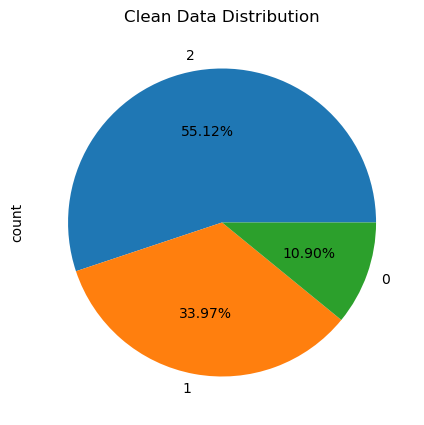

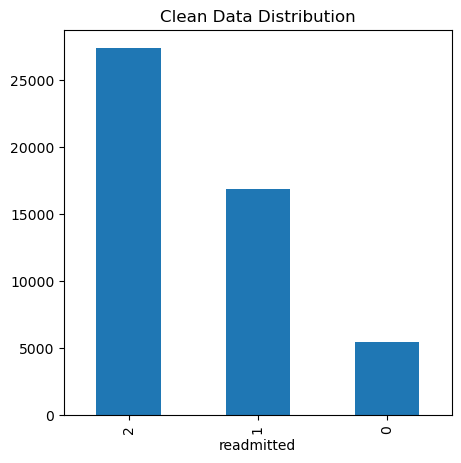

readmitted
2    27414
1    16894
0     5423
Name: count, dtype: int64
readmitted
2    55.124570
1    33.970763
0    10.904667
Name: count, dtype: float64

The baseline should be 55.124570187609336% for the clean data.


In [96]:
#checking the cleaned data baseline
#for 'readmitted': <30 is 0, >30 is 1, and NO is 2.
value_counts_clean = df_clean['readmitted'].value_counts()
value_counts_clean.plot(kind='pie',autopct='%.2f%%',figsize=(15,5))
plt.title('Clean Data Distribution')
plt.show()

value_counts_clean.plot(kind='bar',figsize=(5,5))
plt.title('Clean Data Distribution')
plt.show()

print(value_counts_clean)
percentages_clean = (value_counts_clean / len(df))* 100
print(percentages_clean)
print(f"\nThe baseline should be {percentages_clean[2]}% for the clean data.")

### Correlation Matrix

<Axes: >

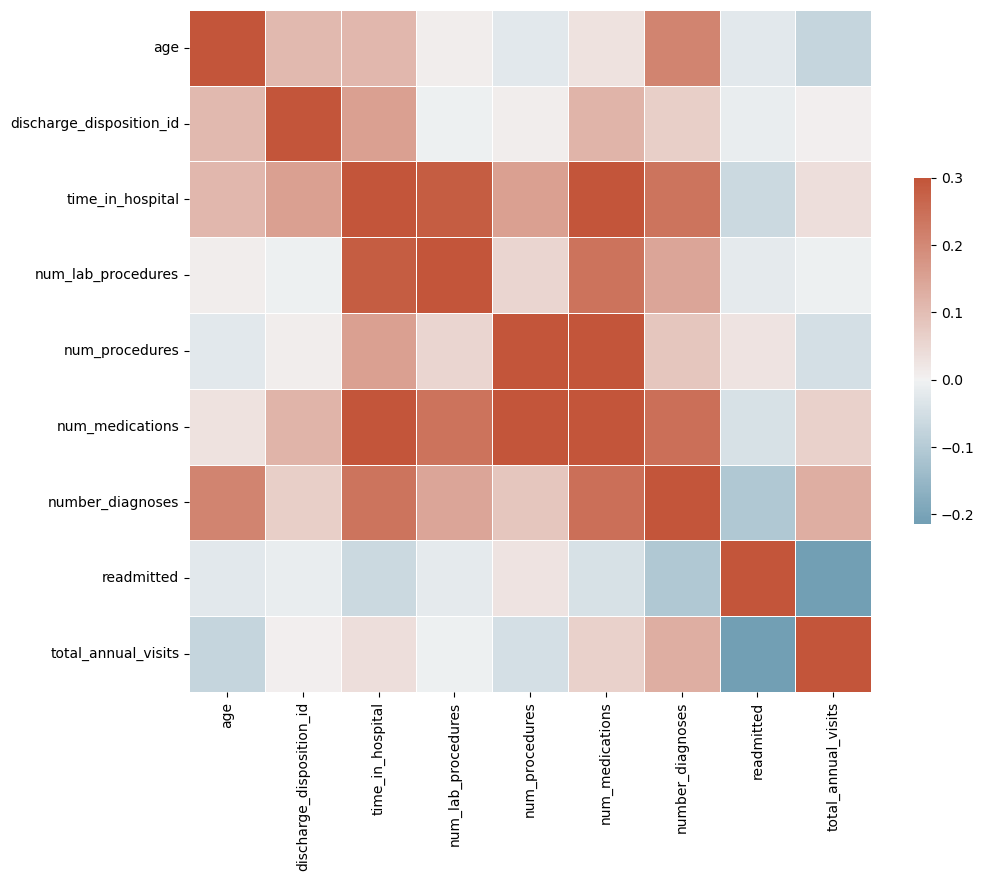

In [98]:
corr_matrix = df_clean.select_dtypes(include=[float,int]).corr()
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20, as_cmap=True)
sns.heatmap(corr_matrix,cmap=cmap,vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink':.5})

In [99]:
df_clean.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'change', 'diabetesMed', 'readmitted', 'total_annual_visits'],
      dtype='object')

In [100]:
X = df_clean.drop(columns=['readmitted'])
y = df_clean['readmitted']

# Define categorical and numerical columns
categorical_columns = ['change', 'diabetesMed', 'gender', 'race',
                       'diag_1', 'diag_2', 'diag_3', 'admission_type_id',
                       'discharge_disposition_id', 'admission_source_id', 'medical_specialty']
numerical_columns = X.columns.drop(categorical_columns).tolist()

# 1. Split into train+validation and test sets (90/10)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 2. Split train+validation into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)

# 3. Create preprocessor for numerical features only
num_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)
    ])

# 4. Fit numerical preprocessor on training data and transform all datasets
X_train_num_scaled = num_preprocessor.fit_transform(X_train)
X_val_num_scaled = num_preprocessor.transform(X_val)
X_test_num_scaled = num_preprocessor.transform(X_test)

# Combine scaled numerical features with original categorical features
X_train_combined = np.column_stack((X_train_num_scaled, X_train[categorical_columns]))
X_val_combined = np.column_stack((X_val_num_scaled, X_val[categorical_columns]))
X_test_combined = np.column_stack((X_test_num_scaled, X_test[categorical_columns]))

# Get the indices of categorical columns in the combined dataset
categorical_indices = list(range(len(numerical_columns), X_train_combined.shape[1]))

# 5. Apply SMOTE-NC to the combined training data
smote_nc = SMOTENC(random_state=42, categorical_features=categorical_indices)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train_combined, y_train)

# 6. Create preprocessor for one-hot encoding categorical features
cat_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), list(range(len(categorical_columns))))
    ])

# 7. Fit categorical preprocessor on resampled training data and transform all datasets
X_train_preprocessed = cat_preprocessor.fit_transform(X_train_resampled[:, len(numerical_columns):])
X_val_preprocessed = cat_preprocessor.transform(X_val_combined[:, len(numerical_columns):])
X_test_preprocessed = cat_preprocessor.transform(X_test_combined[:, len(numerical_columns):])

# Combine numerical features with one-hot encoded categorical features
X_train_final = np.column_stack((X_train_resampled[:, :len(numerical_columns)], X_train_preprocessed))
X_val_final = np.column_stack((X_val_combined[:, :len(numerical_columns)], X_val_preprocessed))
X_test_final = np.column_stack((X_test_combined[:, :len(numerical_columns)], X_test_preprocessed))

# Get feature names after preprocessing
numeric_feature_names = numerical_columns
categorical_feature_names = cat_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Convert to DataFrames and ensure all data is float32
X_train_final = pd.DataFrame(X_train_final, columns=feature_names).astype('float32')
X_val_final = pd.DataFrame(X_val_final, columns=feature_names).astype('float32')
X_test_final = pd.DataFrame(X_test_final, columns=feature_names).astype('float32')

# Convert target variables to numpy arrays
y_train_resampled = np.array(y_train_resampled).astype('float32')
y_val = np.array(y_val).astype('float32')
y_test = np.array(y_test).astype('float32')

# Print the shapes of the resulting datasets
print("Training set shape:", X_train_final.shape)
print("Validation set shape:", X_val_final.shape)
print("Test set shape:", X_test_final.shape)

# Check class distribution in resampled training set
print("\nClass distribution in resampled training set:")
value_counts_smote = pd.Series(y_train_resampled).value_counts(normalize=True)
print(value_counts_smote)

# Print data types
print("\nData types in X_train_final:")
print(X_train_final.dtypes)
print("\nData type of y_train_resampled:", y_train_resampled.dtype)

Training set shape: (65574, 164)
Validation set shape: (4973, 164)
Test set shape: (4974, 164)

Class distribution in resampled training set:
2.0    0.333333
1.0    0.333333
0.0    0.333333
Name: proportion, dtype: float64

Data types in X_train_final:
age                                                   float32
time_in_hospital                                      float32
num_lab_procedures                                    float32
num_procedures                                        float32
num_medications                                       float32
                                                       ...   
medical_specialty_Surgery-PlasticwithinHeadandNeck    float32
medical_specialty_Surgery-Thoracic                    float32
medical_specialty_Surgery-Vascular                    float32
medical_specialty_SurgicalSpecialty                   float32
medical_specialty_Urology                             float32
Length: 164, dtype: object

Data type of y_train_resampled: float

### Sequential Model GridSearch

In [102]:
# def create_model(neurons1=100, neurons2=50, neurons3=25):
#     model = keras.Sequential([
#         layers.Input(shape=(X_train_final.shape[1],)),
#         layers.Dense(neurons1, activation='relu', kernel_regularizer=l2(0.001)),
#         layers.BatchNormalization(),
#         layers.Dropout(0.2),
#         layers.Dense(neurons2, activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dropout(0.2),
#         layers.Dense(neurons3, activation='relu', kernel_regularizer=l2(0.001)),
#         layers.BatchNormalization(),
#         layers.Dropout(0.2),
#         layers.Dense(len(np.unique(y_train_resampled)), activation='softmax')
#     ])
#     optmzr = keras.optimizers.Adam(learning_rate=0.001)
#     model.compile(optimizer=optmzr,
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

# # Wrap the model in KerasClassifier
# model = KerasClassifier(
#     model=create_model,
#     neurons1=100,  # default value
#     neurons2=50,   # default value
#     neurons3=25,   # default value
#     verbose=0,
#     epochs=20,
#     batch_size=256
# )

# # Define the parameter grid
# param_grid = {
#     'neurons1': [150, 200],
#     'neurons2': [50, 100],
#     'neurons3': [25, 40]
# }

# # Create GridSearchCV object
# grid = GridSearchCV(estimator=model, param_grid=param_grid, 
#                     cv=2, n_jobs=1, verbose=2)

# # Fit GridSearchCV
# grid_result = grid.fit(X_train_final, y_train_resampled)

# # Print results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


### OUTPUT ###
# Fitting 2 folds for each of 8 candidates, totalling 16 fits
# [CV] END .............neurons1=150, neurons2=50, neurons3=25; total time=  11.8s
# [CV] END .............neurons1=150, neurons2=50, neurons3=25; total time=  12.4s
# [CV] END .............neurons1=150, neurons2=50, neurons3=40; total time=  14.0s
# [CV] END .............neurons1=150, neurons2=50, neurons3=40; total time=  12.5s
# [CV] END ............neurons1=150, neurons2=100, neurons3=25; total time=  12.3s
# [CV] END ............neurons1=150, neurons2=100, neurons3=25; total time=  12.8s
# [CV] END ............neurons1=150, neurons2=100, neurons3=40; total time=  13.6s
# [CV] END ............neurons1=150, neurons2=100, neurons3=40; total time=  12.3s
# [CV] END .............neurons1=200, neurons2=50, neurons3=25; total time=  12.3s
# [CV] END .............neurons1=200, neurons2=50, neurons3=25; total time=  13.9s
# [CV] END .............neurons1=200, neurons2=50, neurons3=40; total time=  13.2s
# [CV] END .............neurons1=200, neurons2=50, neurons3=40; total time=  12.3s
# [CV] END ............neurons1=200, neurons2=100, neurons3=25; total time=  12.7s
# [CV] END ............neurons1=200, neurons2=100, neurons3=25; total time=  13.3s
# [CV] END ............neurons1=200, neurons2=100, neurons3=40; total time=  13.6s
# [CV] END ............neurons1=200, neurons2=100, neurons3=40; total time=  14.8s
# Best: 0.564523 using {'neurons1': 200, 'neurons2': 100, 'neurons3': 40}
# 0.549425 (0.017263) with: {'neurons1': 150, 'neurons2': 50, 'neurons3': 25}
# 0.549242 (0.013054) with: {'neurons1': 150, 'neurons2': 50, 'neurons3': 40}
# 0.555876 (0.012825) with: {'neurons1': 150, 'neurons2': 100, 'neurons3': 25}
# 0.557325 (0.016561) with: {'neurons1': 150, 'neurons2': 100, 'neurons3': 40}
# 0.560573 (0.016760) with: {'neurons1': 200, 'neurons2': 50, 'neurons3': 25}
# 0.558636 (0.013359) with: {'neurons1': 200, 'neurons2': 50, 'neurons3': 40}
# 0.564157 (0.021472) with: {'neurons1': 200, 'neurons2': 100, 'neurons3': 25}
# 0.564523 (0.016134) with: {'neurons1': 200, 'neurons2': 100, 'neurons3': 40}

### Sequential Model

In [104]:
def create_model(input_shape, output_shape):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(152, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(68, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(42, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(output_shape, activation='softmax')
    ])
    optmzr = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optmzr,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and train the model
model = create_model(X_train_final.shape[1], len(np.unique(y_train_resampled)))

# Learning rate scheduler and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-12)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_final, y_train_resampled,
                    epochs=30,  # Adjust epochs as needed
                    batch_size=256,
                    validation_data=(X_val_final, y_val),
                    callbacks=[reduce_lr, early_stopping],
                    verbose=1)

# Get predictions
y_pred_proba = model.predict(X_test_final)
y_pred = np.argmax(y_pred_proba, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate specificity for each class
def specificity(y_true, y_pred, class_id):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.sum(cm) - np.sum(cm[class_id, :]) - np.sum(cm[:, class_id]) + cm[class_id, class_id]
    fp = np.sum(cm[:, class_id]) - cm[class_id, class_id]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Get classification report
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print(f"Sequential Test Accuracy = {report['accuracy'] * 100:.4f}%\n")

# Get unique classes
unique_classes = np.unique(np.concatenate((y_test, y_pred)))

# Initialize dictionaries to hold metrics
metrics = {str(cls): {} for cls in unique_classes}

# Extract metrics from report and calculate specificity
for class_name in metrics.keys():
    if class_name in report:
        metrics[class_name]['recall'] = report[class_name]['recall']
        metrics[class_name]['precision'] = report[class_name]['precision']
        class_index = np.where(unique_classes == float(class_name))[0][0]
        metrics[class_name]['specificity'] = specificity(y_test, y_pred, class_index)
    else:
        print(f"Warning: Class {class_name} not found in the classification report.")
        metrics[class_name]['recall'] = 0
        metrics[class_name]['precision'] = 0
        metrics[class_name]['specificity'] = 0

# Print metrics for each class
for class_name, class_metrics in metrics.items():
    print(f"{class_name}: Recall = {class_metrics['recall']:.4f}, "
          f"Specificity = {class_metrics['specificity']:.4f}, "
          f"Precision = {class_metrics['precision']:.4f}")

# Print average results
avg_recall = np.mean([m['recall'] for m in metrics.values()])
avg_specificity = np.mean([m['specificity'] for m in metrics.values()])
avg_precision = np.mean([m['precision'] for m in metrics.values()])
print(f"\nAverage Recall: {avg_recall:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

# # Debugging information
# print("\nDebugging Information:")
# print("Unique values in y_test:", np.unique(y_test))
# print("Unique values in y_pred:", np.unique(y_pred))
# print("Keys in classification report:", report.keys())
# print("Unique classes:", unique_classes)

Epoch 1/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3983 - loss: 1.4815 - val_accuracy: 0.4112 - val_loss: 1.2000 - learning_rate: 0.0010
Epoch 2/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4644 - loss: 1.1583 - val_accuracy: 0.4583 - val_loss: 1.1377 - learning_rate: 0.0010
Epoch 3/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4885 - loss: 1.0933 - val_accuracy: 0.4631 - val_loss: 1.1072 - learning_rate: 0.0010
Epoch 4/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5042 - loss: 1.0545 - val_accuracy: 0.4818 - val_loss: 1.0766 - learning_rate: 0.0010
Epoch 5/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5190 - loss: 1.0267 - val_accuracy: 0.4800 - val_loss: 1.0613 - learning_rate: 0.0010
Epoch 6/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5319 - loss: 1.0012 - val_accuracy: 0.4818 - val_loss: 1.0476 - learning_rate: 0.0010
Epoch 7/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5355 - loss: 0.9902 - 

In [105]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 152)                 │          25,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 152)                 │             608 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 152)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 68)                  │          10,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 68)                  │             272 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 68)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 42)                  │           2,898 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 42)                  │             168 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 42)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,631 (459.50 KB)

 Trainable params: 39,035 (152.48 KB)

 Non-trainable params: 524 (2.05 KB)

 Optimizer params: 78,072 (304.97 KB)

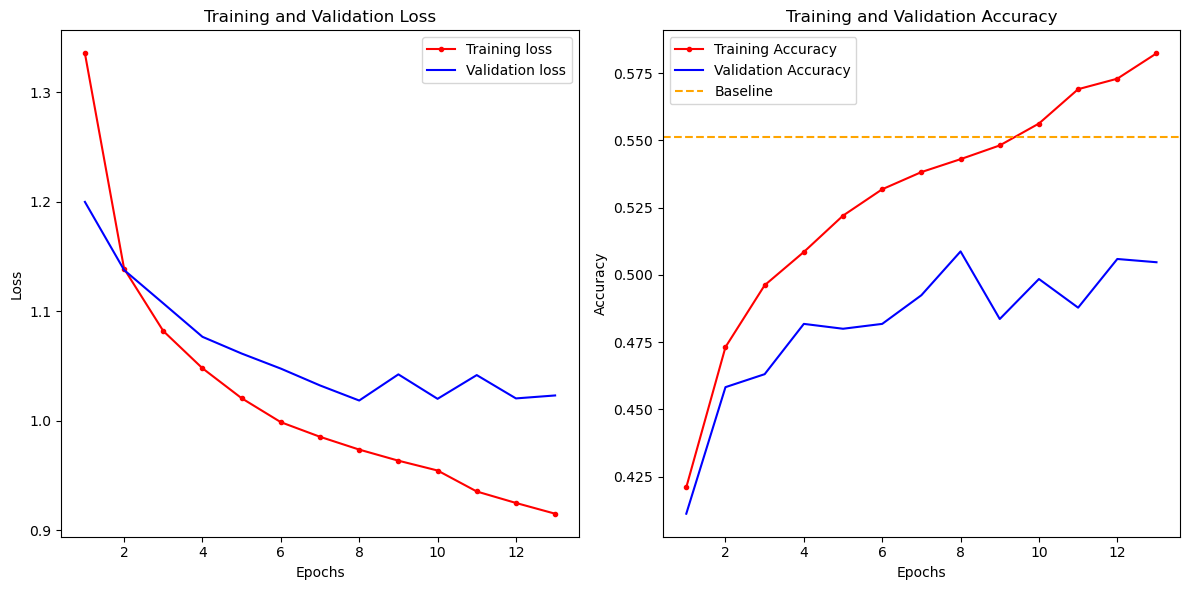

In [106]:
history_dict = history.history  # Get the history from the trained model

# Create a figure for plotting
plt.figure(figsize=(12, 6))  # Adjust the size as needed

# Loss Plot
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.subplot(1, 2, 1)  # Create a subplot for loss
plt.plot(epochs, loss_values, 'ro-', markersize=3, label="Training loss")  # Training loss
plt.plot(epochs, val_loss_values, 'b-', label='Validation loss')  # Validation loss
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
acc = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.subplot(1, 2, 2)  # Create a subplot for accuracy
plt.plot(epochs, acc, 'ro-', markersize=3, label='Training Accuracy')  # Training accuracy
plt.plot(epochs, val_acc_values, 'b-', label='Validation Accuracy')  # Validation accuracy
plt.axhline(y=value_counts_clean[2]/sum(value_counts_clean), color='orange', linestyle ='--', label='Baseline') # Baseline for majority class
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plots

2050/2050 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


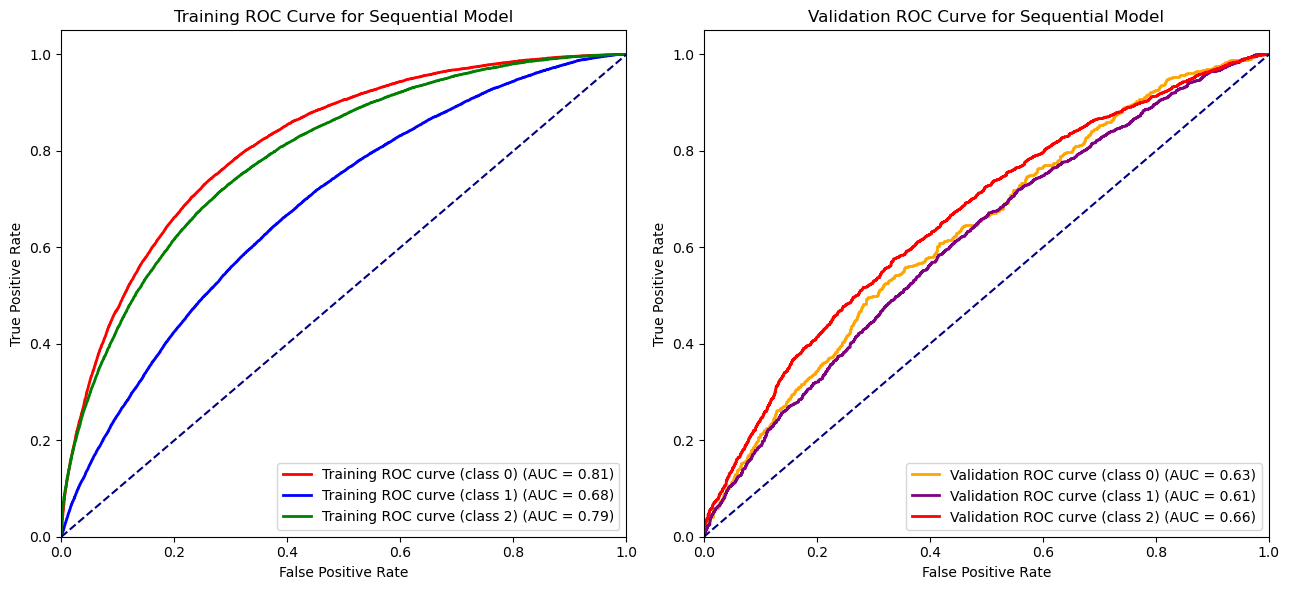

In [107]:
# Binarize the output (one-vs-all) for multi-class classification
y_train_binarized = label_binarize(y_train_resampled, classes=np.unique(y_train_resampled))
y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_train_binarized.shape[1]  # Number of classes

# Get predicted probabilities for the train set
y_pred_proba_train = model.predict(X_train_final)  # Shape: (n_samples, n_classes)
# Get predicted probabilities for the validation set
y_pred_proba_val = model.predict(X_val_final)  # Shape: (n_samples, n_classes)

# Compute ROC curve and ROC area for each class
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

# Compute the ROC curve for each class
for i in range(n_classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba_train[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_binarized[:, i], y_pred_proba_val[:, i])
    roc_auc_val[i] = auc(fpr_val[i], tpr_val[i])

# Plot ROC curve for the training and validation sets
plt.figure(figsize=(13, 6))  # Adjust the size as needed

# Create a subplot for the ROC curve
plt.subplot(1, 2, 1)  # Left side for training ROC curve

# Plot ROC curve for each class in training set
colors = cycle(['red', 'blue', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2,
             label=f'Training ROC curve (class {i}) (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Training ROC Curve for Sequential Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Create a subplot for the ROC curve of the validation set
plt.subplot(1, 2, 2)  # Right side for validation ROC curve

# Plot ROC curve for each class in validation set
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2,
             label=f'Validation ROC curve (class {i}) (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Validation ROC Curve for Sequential Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.tight_layout()  # Adjust layout
plt.show()  # Display the plots

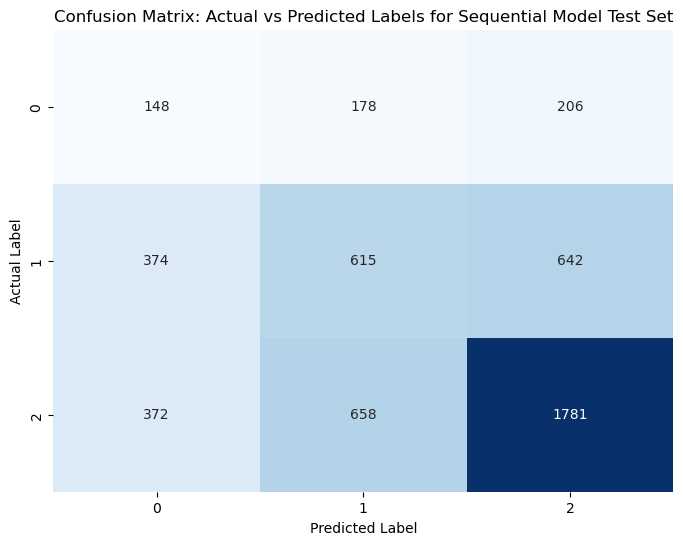

In [108]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix: Actual vs Predicted Labels for Sequential Model Test Set')
plt.show()

### Random Forest Model GridSearch

In [110]:
# # Define the parameter grid
# param_grid = {
#     'n_estimators': [25, 50],
#     'max_depth': [15,20],
#     'max_features': ['sqrt', 'log2']
# }

# # Initialize the Random Forest Classifier
# rf_classifier = RandomForestClassifier(
#     n_estimators=50,
#     max_depth=15,
#     min_samples_split=10,     
#     min_samples_leaf=8,
#     max_features='sqrt',
#     random_state=42
# )

# # Set up the grid search
# grid_search = GridSearchCV(
#     estimator=rf_classifier,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,  # Use all available cores
#     verbose=2,
#     scoring=make_scorer(f1_score, average='weighted')
# )

# # Fit the grid search
# grid_search.fit(X_train_final, y_train_resampled)

# # Print the best parameters and score
# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)

# # Get the best model
# best_rf_classifier = grid_search.best_estimator_

# # Evaluate on the test set
# test_score = best_rf_classifier.score(X_test_final, y_test)
# print("Test set score with best model:", test_score)

# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 50}
# Best cross-validation score: 0.5826879632905169
# Test set score with best model: 0.5516686771210294

### Random Forest Model

In [112]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=50,
    max_depth=20,
    min_samples_split=10,     
    min_samples_leaf=8,
    max_features='sqrt',
    random_state=42
)

# Fit the Random Forest model
rf_classifier.fit(X_train_final, y_train_resampled)

# Get predictions for the test set
y_pred_rf = rf_classifier.predict(X_test_final)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Calculate specificity for each class
def specificity(y_true, y_pred, class_id):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.sum(cm) - np.sum(cm[class_id, :]) - np.sum(cm[:, class_id]) + cm[class_id, class_id]
    fp = np.sum(cm[:, class_id]) - cm[class_id, class_id]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Get classification report
report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
print(f"Sequential Test Accuracy = {report_rf['accuracy'] * 100:.4f}%\n")

# Get unique classes
unique_classes = np.unique(np.concatenate((y_test, y_pred_rf)))

# Initialize dictionaries to hold metrics
metrics_rf = {str(cls): {} for cls in unique_classes}

# Extract metrics from report and calculate specificity
for class_name in metrics_rf.keys():
    if class_name in report:
        metrics_rf[class_name]['recall'] = report_rf[class_name]['recall']
        metrics_rf[class_name]['precision'] = report_rf[class_name]['precision']
        class_index = np.where(unique_classes == float(class_name))[0][0]
        metrics_rf[class_name]['specificity'] = specificity(y_test, y_pred_rf, class_index)
    else:
        print(f"Warning: Class {class_name} not found in the classification report.")
        metrics_rf[class_name]['recall'] = 0
        metrics_rf[class_name]['precision'] = 0
        metrics_rf[class_name]['specificity'] = 0

# Print metrics for each class
for class_name, class_metrics in metrics_rf.items():
    print(f"{class_name}: Recall = {class_metrics['recall']:.4f}, "
          f"Specificity = {class_metrics['specificity']:.4f}, "
          f"Precision = {class_metrics['precision']:.4f}")

# Print average results
avg_recall = np.mean([m['recall'] for m in metrics_rf.values()])
avg_specificity = np.mean([m['specificity'] for m in metrics_rf.values()])
avg_precision = np.mean([m['precision'] for m in metrics_rf.values()])
print(f"\nAverage Recall: {avg_recall:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

# # Debugging information
# print("\nDebugging Information:")
# print("Unique values in y_test:", np.unique(y_test))
# print("Unique values in y_pred:", np.unique(y_pred_rf))
# print("Keys in classification report:", report_rf.keys())
# print("Unique classes:", unique_classes)

Sequential Test Accuracy = 55.1669%

0.0: Recall = 0.2368, Specificity = 0.8908, Precision = 0.2062
1.0: Recall = 0.3789, Specificity = 0.7774, Precision = 0.4537
2.0: Recall = 0.7115, Specificity = 0.5372, Precision = 0.6664

Average Recall: 0.4424
Average Specificity: 0.7352
Average Precision: 0.4421


In [113]:
# Number of trees in the forest
n_trees = len(rf_classifier.estimators_)
print(f"Number of trees: {n_trees}")

# Depth of each tree
tree_depths = [estimator.tree_.max_depth for estimator in rf_classifier.estimators_]
print(f"Depth of each tree: {tree_depths}")
print(f"Average tree depth: {np.mean(tree_depths):.2f}")

# Feature importances
feature_importances = rf_classifier.feature_importances_
print("\nFeature importances:")
feature_names = X_train_final.columns
for name, importance in zip(feature_names, feature_importances):
    print(f"{name}: {importance:.4f}")

# Out-of-bag (OOB) score
if hasattr(rf_classifier, 'oob_score_'):
    print(f"\nOOB Score: {rf_classifier.oob_score_:.4f}")

# Check class distribution across trees
#for i, estimator in enumerate(rf_classifier.estimators_):
    #print(f"Tree {i + 1} class distribution: {estimator.tree_.value}")

# Visualizing a single tree
# tree_text = export_text(rf_classifier.estimators_[0], feature_names=list(feature_names))
# print("Tree structure of the first tree:")
# print(tree_text)

Number of trees: 50
Depth of each tree: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
Average tree depth: 20.00

Feature importances:
age: 0.0611
time_in_hospital: 0.0698
num_lab_procedures: 0.0524
num_procedures: 0.0504
num_medications: 0.0559
number_diagnoses: 0.0743
total_annual_visits: 0.1798
change_Ch: 0.0080
change_No: 0.0089
diabetesMed_No: 0.0132
diabetesMed_Yes: 0.0109
gender_Female: 0.0106
gender_Male: 0.0107
race_AfricanAmerican: 0.0077
race_Asian: 0.0004
race_Caucasian: 0.0123
race_Hispanic: 0.0014
race_Other: 0.0012
diag_1_Diabetes Mellitus: 0.0041
diag_1_Diseases of the Circulatory System: 0.0272
diag_1_Diseases of the Digestive System: 0.0052
diag_1_Diseases of the Genitourinary System: 0.0024
diag_1_Diseases of the Musculoskeletal System & Connective Tissue: 0.0038
diag_1_Diseases of the Respiratory System: 0.0065
dia

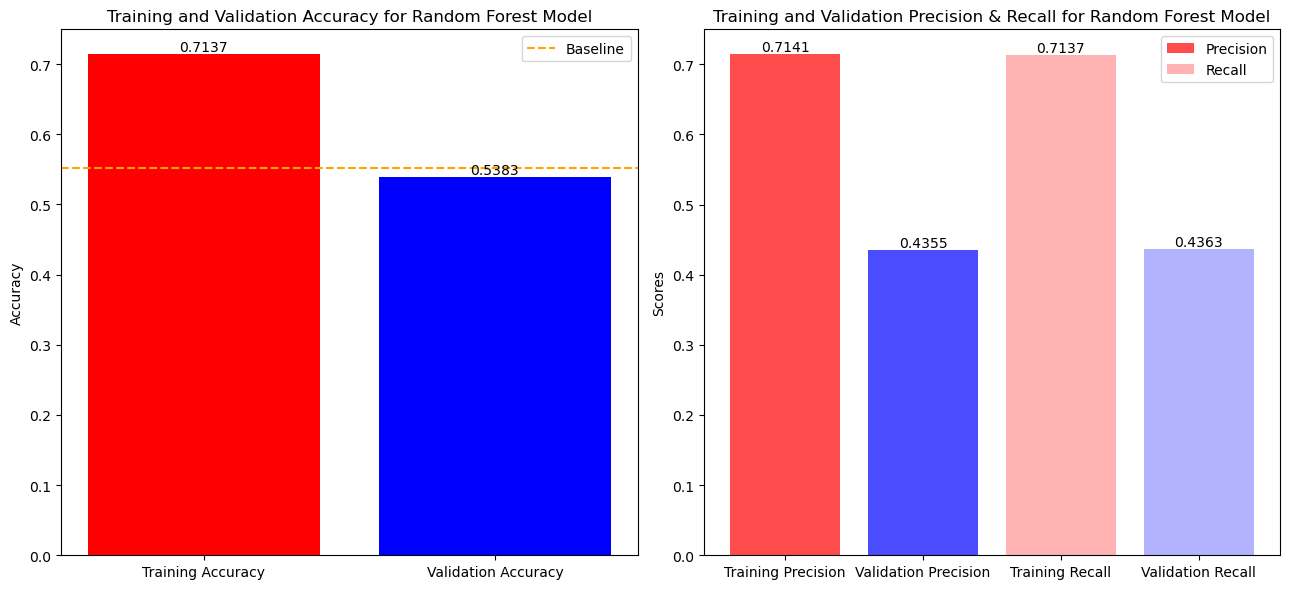

In [114]:
# Generate predictions for the original training set (X_train) and validation set (X_val)
y_train_pred_rf = rf_classifier.predict(X_train_final)  # Predictions on training data
y_val_pred_rf = rf_classifier.predict(X_val_final)  # Predictions on validation data

# Get accuracy for the original training set and validation set
train_accuracy_rf = accuracy_score(y_train_resampled, y_train_pred_rf)
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)

# Compute precision, recall, f1-score for the original training and validation sets
train_precision_rf, train_recall_rf, _, _ = precision_recall_fscore_support(
    y_train_resampled, y_train_pred_rf, average='macro', zero_division=0
)
val_precision_rf, val_recall_rf, _, _ = precision_recall_fscore_support(
    y_val, y_val_pred_rf, average='macro', zero_division=0
)

# Prepare data for plotting
metrics_rf = {
    'Training Accuracy': train_accuracy_rf,
    'Validation Accuracy': val_accuracy_rf,
    'Training Precision': train_precision_rf,
    'Validation Precision': val_precision_rf,
    'Training Recall': train_recall_rf,
    'Validation Recall': val_recall_rf
}

# Create a figure for plotting
plt.figure(figsize=(13, 6))  # Adjust the size as needed

# Plot Accuracy
plt.subplot(1, 2, 1)  # Create a subplot for accuracy
bars = plt.bar(['Training Accuracy', 'Validation Accuracy'], 
        [metrics_rf['Training Accuracy'], metrics_rf['Validation Accuracy']], 
        color=['red', 'blue'])
plt.bar_label(bars, fmt='%.4f')
plt.axhline(y=value_counts_clean[2]/sum(value_counts_clean), color='orange', linestyle ='--', label='Baseline')  # Baseline for majority class
plt.title('Training and Validation Accuracy for Random Forest Model')
plt.ylabel('Accuracy')
plt.legend()

# Plot Precision and Recall
plt.subplot(1, 2, 2)  # Create a subplot for precision and recall
bars2 = plt.bar(['Training Precision', 'Validation Precision'], 
        [metrics_rf['Training Precision'], metrics_rf['Validation Precision']], 
        color=['red', 'blue'], alpha=0.7, label='Precision')
plt.bar_label(bars2, fmt='%.4f')
bars3 = plt.bar(['Training Recall', 'Validation Recall'], 
        [metrics_rf['Training Recall'], metrics_rf['Validation Recall']], 
        color=['red', 'blue'], alpha=0.3, label='Recall')
plt.bar_label(bars3, fmt='%.4f')
plt.title('Training and Validation Precision & Recall for Random Forest Model')
plt.ylabel('Scores')
plt.legend()

plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plots

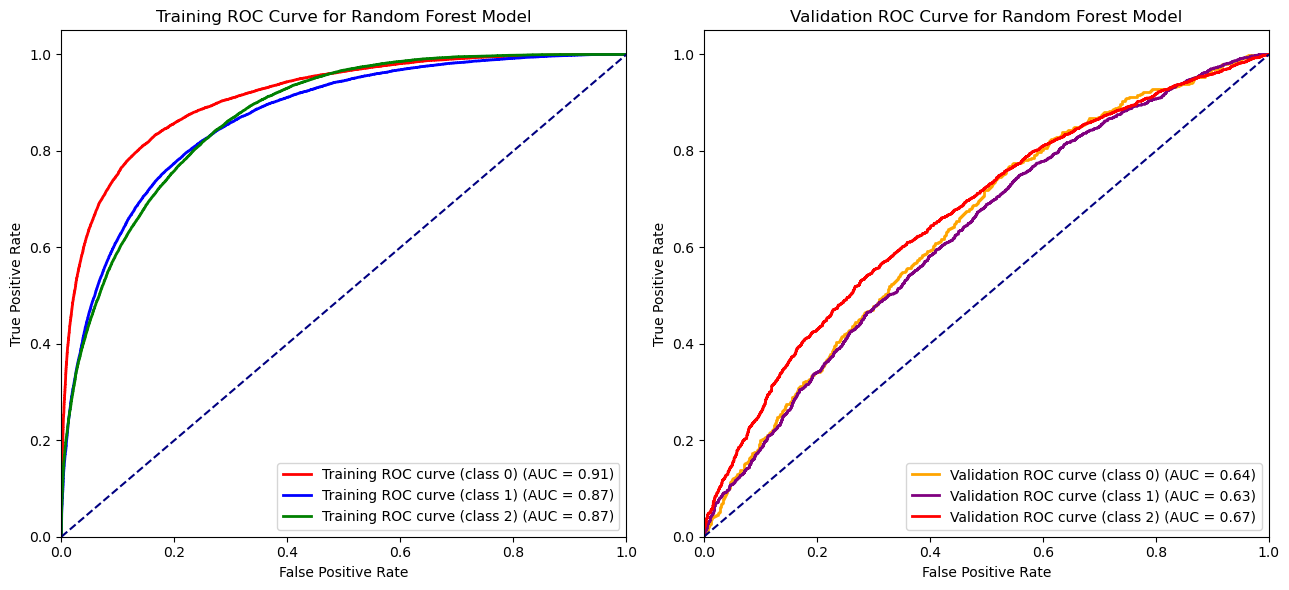

In [115]:
# Binarize the output (one-vs-all) for multi-class classification
y_train_binarized = label_binarize(y_train_resampled, classes=np.unique(y_train_resampled))
y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_train_binarized.shape[1]  # Number of classes

# Generate probability predictions for ROC curve
y_train_prob_rf = rf_classifier.predict_proba(X_train_final)  # Probability estimates for the training set
y_val_prob_rf = rf_classifier.predict_proba(X_val_final)  # Probability estimates for the validation set

# Compute ROC curve and ROC area for each class
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

# Compute the ROC curve for each class
for i in range(n_classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_binarized[:, i], y_train_prob_rf[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_binarized[:, i], y_val_prob_rf[:, i])
    roc_auc_val[i] = auc(fpr_val[i], tpr_val[i])

# Plot ROC curve for the training and validation sets
plt.figure(figsize=(13, 6))  # Adjust the size as needed

# Create a subplot for the ROC curve
plt.subplot(1, 2, 1)  # Left side for training ROC curve

# Plot ROC curve for each class in training set
colors = cycle(['red', 'blue', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2,
             label=f'Training ROC curve (class {i}) (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Training ROC Curve for Random Forest Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Create a subplot for the ROC curve of the validation set
plt.subplot(1, 2, 2)  # Right side for validation ROC curve

# Plot ROC curve for each class in validation set
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2,
             label=f'Validation ROC curve (class {i}) (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Validation ROC Curve for Random Forest Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.tight_layout()  # Adjust layout
plt.show()  # Display the plots

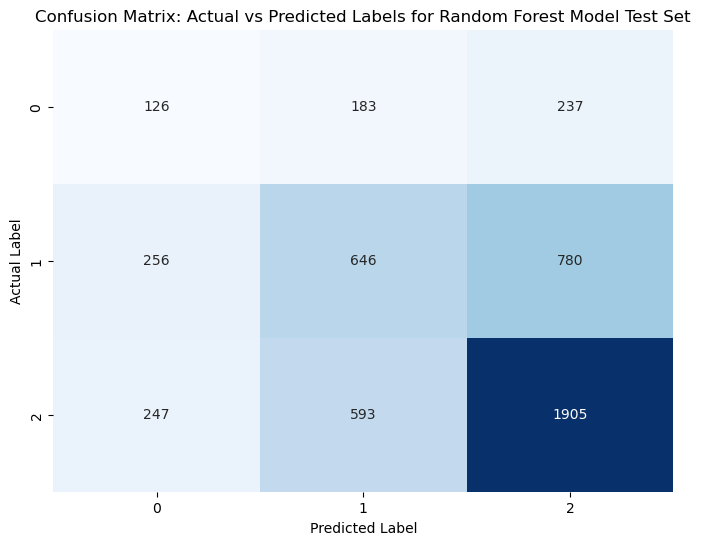

In [116]:
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix: Actual vs Predicted Labels for Random Forest Model Test Set')
plt.show()

### 2-Class Models

In [118]:
def age_range_to_mean(age_range):
    if isinstance(age_range, str):
        lower_bound = int(age_range.split('-')[0][1:])
        upper_bound = int(age_range.split('-')[1][:-1])
        return (lower_bound + upper_bound) / 2
    else:
        return age_range
    
# Apply the age function if needed
if df['age'].dtype == 'object':
    df['age'] = df['age'].apply(age_range_to_mean)

readmission_mapping = {2:1, '<30': 0, '>30':1, 'NO':1}
df['readmitted'] = df['readmitted'].replace(readmission_mapping)
df2['readmitted'] = df2['readmitted'].replace(readmission_mapping)

df_clean2 = df

C:\Users\pazul\AppData\Local\Temp\ipykernel_9608\4032194172.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['readmitted'] = df2['readmitted'].replace(readmission_mapping)


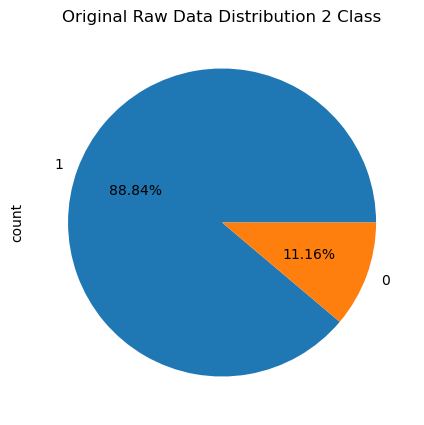

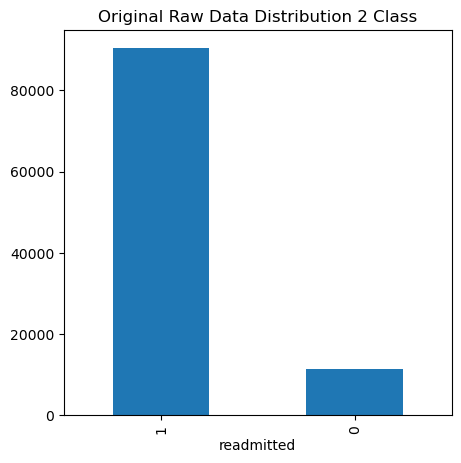

readmitted
1    90409
0    11357
Name: count, dtype: int64
readmitted
1    88.840084
0    11.159916
Name: count, dtype: float64

The baseline should be 88.84008411453728% for the original raw data.


In [119]:
#checking the original raw data baseline
value_counts2 = df2['readmitted'].value_counts()
value_counts2.plot(kind='pie',autopct='%.2f%%',figsize=(15,5))
plt.title('Original Raw Data Distribution 2 Class')
plt.show()

value_counts2.plot(kind='bar',figsize=(5,5))
plt.title('Original Raw Data Distribution 2 Class')
plt.show()

print(value_counts2)
percentages2 = (value_counts2 / len(df2))* 100
print(percentages2)
print(f"\nThe baseline should be {percentages2[1]}% for the original raw data.")

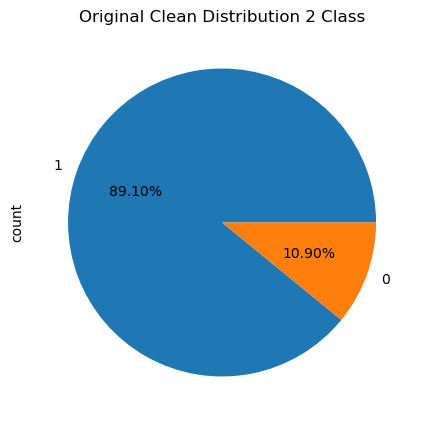

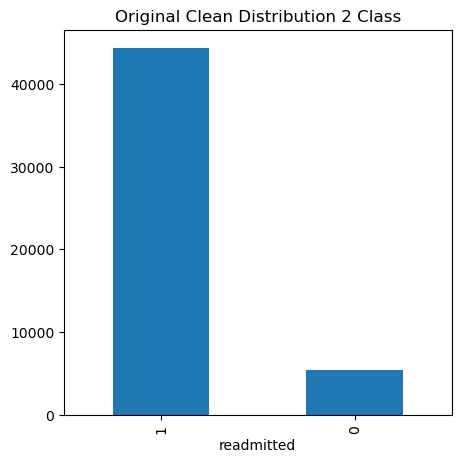

readmitted
1    44308
0     5423
Name: count, dtype: int64
readmitted
1    89.095333
0    10.904667
Name: count, dtype: float64

The baseline should be 89.09533289095333% for the clean data.


In [120]:
#checking the original raw data baseline
value_counts2_clean = df_clean2['readmitted'].value_counts()
value_counts2_clean.plot(kind='pie',autopct='%.2f%%',figsize=(15,5))
plt.title('Original Clean Distribution 2 Class')
plt.show()

value_counts2_clean.plot(kind='bar',figsize=(5,5))
plt.title('Original Clean Distribution 2 Class')
plt.show()

print(value_counts2_clean)
percentages2_clean = (value_counts2_clean / len(df))* 100
print(percentages2_clean)
print(f"\nThe baseline should be {percentages2_clean[1]}% for the clean data.")

In [121]:
def ohe_norm(df_1):
    # One-hot encode categorical columns
    other_categorical_columns = ['change', 'diabetesMed', 'gender', 'race',
                                 'diag_1', 'diag_2', 'diag_3', 'admission_type_id',
                                 'discharge_disposition_id', 'admission_source_id', 'medical_specialty']
    columns_to_encode = [col for col in other_categorical_columns if col in df_1.columns]

    if columns_to_encode:
        df_1 = pd.get_dummies(df_1, columns=columns_to_encode, dtype=float)

    # Normalize specified columns
    normalize_columns = ['num_procedures', 'num_medications', 'age',
                         'total_annual_visits', 'number_diagnoses', 'time_in_hospital', 'num_lab_procedures']
    scaler = StandardScaler()
    df_1[normalize_columns] = scaler.fit_transform(df_1[normalize_columns])

    return df_1

df_clean2 = ohe_norm(df_clean2)

In [122]:
from tensorflow.keras.utils import to_categorical
X_2 = df_clean2.drop(columns=['readmitted'])
y_2 = to_categorical(df_clean2['readmitted'])

# 1. Split into train+validation and test sets (90/10)
X_temp_2, X_test_2, y_temp_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.1, random_state=42)
# 2. Split train+validation into train and validation sets
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_temp_2, y_temp_2, test_size=1/9, random_state=42)

### Sequential Model

In [124]:
def create_model_2(input_shape, output_shape):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        # layers.Dense(152, activation='relu', kernel_regularizer=l2(0.001)),
        # layers.BatchNormalization(),
        # layers.Dropout(0.3),
        layers.Dense(68, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(42, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(output_shape, activation='softmax')
    ])
    optmzr = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optmzr,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and train the model
model2 = create_model_2(X_train_2.shape[1], len(np.unique(y_train_2)))

# Learning rate scheduler and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-12)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history2 = model2.fit(X_train_2, y_train_2,
                    epochs=30,  # Adjust epochs as needed
                    batch_size=256,
                    validation_data=(X_val_2, y_val_2),
                    callbacks=[reduce_lr, early_stopping],
                    verbose=1)

y_pred_proba = model2.predict(X_test_2)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_2 = np.argmax(y_test_2, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_2, y_pred)

# Calculate specificity for the negative class (class 0)
def specificity2(y_true, y_pred, class_id):
    cm = confusion_matrix(y_true, y_pred)
    if class_id == 0:  # For class 0
        tn = cm[0, 0]
        fp = cm[0, 1]
    else:  # For class 1
        tn = cm[1, 1]
        fp = cm[1, 0]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Get classification report
report = classification_report(y_test_2, y_pred, output_dict=True, zero_division=0)
print(f"Sequential Test Accuracy = {report['accuracy'] * 100:.4f}%\n")

# Get unique classes (for a binary classification, this should be [0, 1])
unique_classes = np.unique(np.concatenate((y_test_2, y_pred)))

# Initialize dictionary to hold metrics
metrics = {str(int(cls)): {} for cls in unique_classes}  # Ensure class names are treated as integers

# Extract metrics from the classification report and calculate specificity
for class_name in metrics.keys():
    if class_name in report:
        metrics[class_name]['recall'] = report[class_name]['recall']
        metrics[class_name]['precision'] = report[class_name]['precision']
        class_index = int(class_name)  # Convert class name to integer
        metrics[class_name]['specificity'] = specificity2(y_test_2, y_pred, class_index)
    else:
        print(f"Warning: Class {class_name} not found in the classification report.")
        metrics[class_name]['recall'] = 0
        metrics[class_name]['precision'] = 0
        metrics[class_name]['specificity'] = 0

# Print metrics for each class (0 and 1)
for class_name, class_metrics in metrics.items():
    print(f"{class_name}: Recall = {class_metrics['recall']:.4f}, "
          f"Specificity = {class_metrics['specificity']:.4f}, "
          f"Precision = {class_metrics['precision']:.4f}")

# Print average results (for binary classification, averaging the two classes)
avg_recall = np.mean([m['recall'] for m in metrics.values()])
avg_specificity = np.mean([m['specificity'] for m in metrics.values()])
avg_precision = np.mean([m['precision'] for m in metrics.values()])
print(f"\nAverage Recall: {avg_recall:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

# Optional Debugging Information:
# print("\nDebugging Information:")
# print("Unique values in y_test_2:", np.unique(y_test_2))
# print("Unique values in y_pred:", np.unique(y_pred))
# print("Keys in classification report:", report.keys())
# print("Unique classes:", unique_classes)

Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5627 - loss: 1.0491 - val_accuracy: 0.8902 - val_loss: 0.4763 - learning_rate: 0.0010
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8057 - loss: 0.5291 - val_accuracy: 0.8900 - val_loss: 0.3949 - learning_rate: 0.0010
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8717 - loss: 0.4400 - val_accuracy: 0.8904 - val_loss: 0.3777 - learning_rate: 0.0010
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8860 - loss: 0.4020 - val_accuracy: 0.8900 - val_loss: 0.3704 - learning_rate: 0.0010
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8878 - loss: 0.3921 - val_accuracy: 0.8900 - val_loss: 0.3639 - learning_rate: 0.0010
Epoch 6/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8884 - loss: 0.3827 - val_accuracy: 0.8902 - val_loss: 0.3583 - learning_rate: 0.0010
Epoch 7/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8882 - loss: 0.3742 - 

In [182]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 68)                  │          11,356 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 68)                  │             272 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 68)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 42)                  │           2,898 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 42)                  │             168 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 42)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │              86 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,902 (171.50 KB)

 Trainable params: 14,560 (56.88 KB)

 Non-trainable params: 220 (880.00 B)

 Optimizer params: 29,122 (113.76 KB)

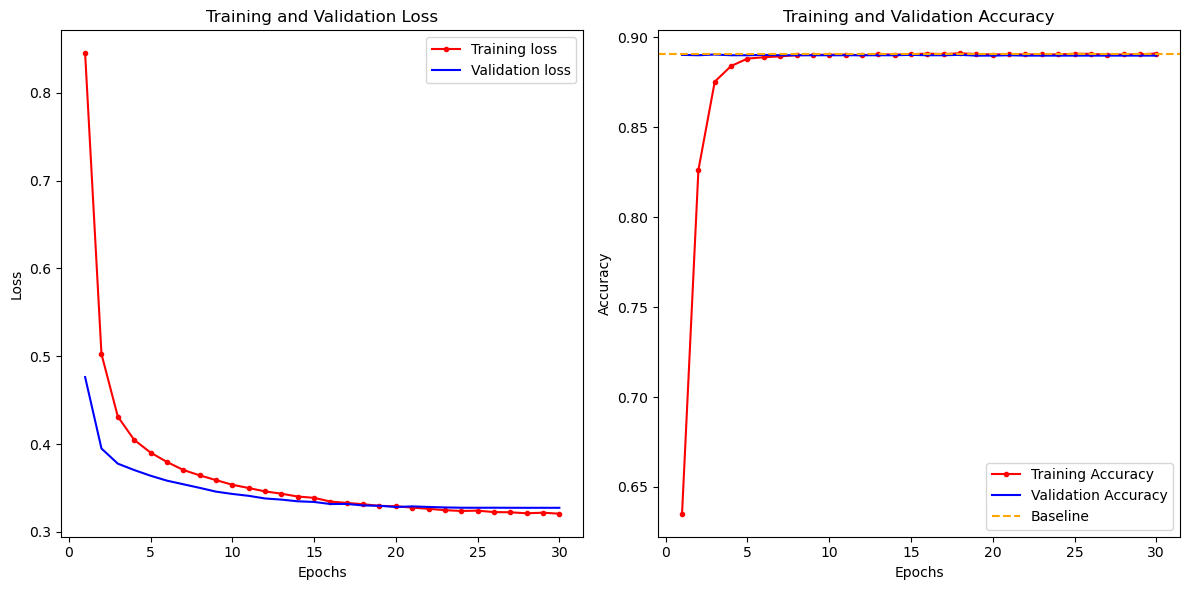

In [125]:
history_dict = history2.history  # Get the history from the trained model

# Create a figure for plotting
plt.figure(figsize=(12, 6))  # Adjust the size as needed

# Loss Plot
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.subplot(1, 2, 1)  # Create a subplot for loss
plt.plot(epochs, loss_values, 'ro-', markersize=3, label="Training loss")  # Training loss
plt.plot(epochs, val_loss_values, 'b-', label='Validation loss')  # Validation loss
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
acc = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.subplot(1, 2, 2)  # Create a subplot for accuracy
plt.plot(epochs, acc, 'ro-', markersize=3, label='Training Accuracy')  # Training accuracy
plt.plot(epochs, val_acc_values, 'b-', label='Validation Accuracy')  # Validation accuracy
plt.axhline(y=value_counts2_clean[1]/sum(value_counts2_clean), color='orange', linestyle ='--', label='Baseline') # Baseline for majority class
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plots

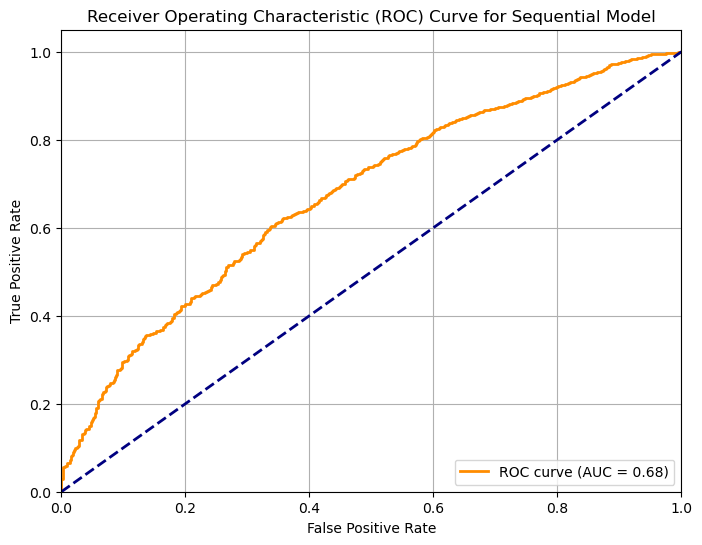

AUC: 0.6762


In [126]:
def plot_roc_curve(y_true, y_pred_proba, title):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Assuming you have already trained your model and have y_test_2 and y_pred_proba
# If not, you need to get these from your model first
# y_test_2 should be the true labels (not one-hot encoded)
# y_pred_proba should be the predicted probabilities for each class

# Convert y_test_2 back to binary format if it's one-hot encoded
if len(y_test_2.shape) > 1 and y_test_2.shape[1] > 1:
    y_test_2 = np.argmax(y_test_2, axis=1)

# Plot the ROC curve
plot_roc_curve(y_test_2, y_pred_proba, 'Receiver Operating Characteristic (ROC) Curve for Sequential Model')

# Print AUC score
print(f"AUC: {auc(roc_curve(y_test_2, y_pred_proba[:, 1])[0], roc_curve(y_test_2, y_pred_proba[:, 1])[1]):.4f}")

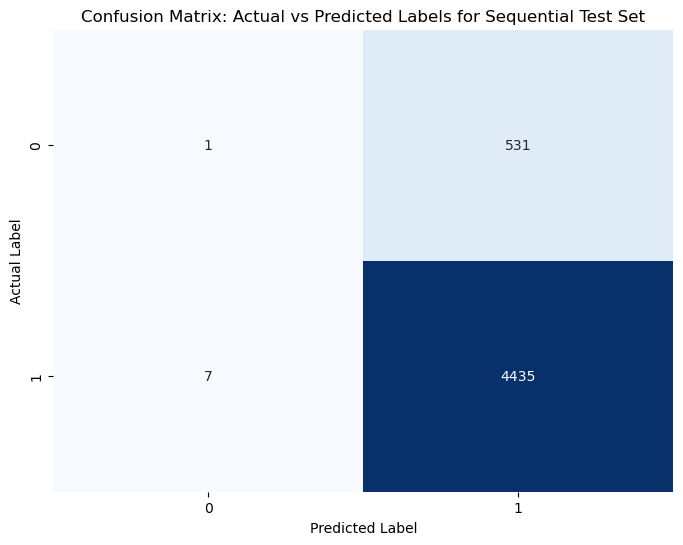

In [127]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix: Actual vs Predicted Labels for Sequential Test Set')
plt.show()

### Random Forest Model

In [129]:
X_train_rf2 = X_train_2.copy()
X_val_rf2 = X_val_2.copy()
X_test_rf2 = X_test_2.copy()
y_train_rf2 = y_train_2.copy()
y_val_rf2 = y_val_2.copy()
y_test_rf2 = y_test_2.copy()

# Check if the target variables are already 1D arrays of class labels
if y_train_rf2.ndim == 1:
    print("Target variable already in the correct format.")
else:
    y_train_rf2 = np.argmax(y_train_rf2, axis=1)
if y_val_rf2.ndim == 1:
    print("Target variable already in the correct format.")
else:
    y_val_rf2 = np.argmax(y_val_rf2, axis=1)
    
if y_test_rf2.ndim == 1:
    print("Target variable already in the correct format.")
else:
    y_test_rf2 = np.argmax(y_test_rf2, axis=1)

# Scale the features
scaler_rf2 = StandardScaler()
X_train_scaled_rf2 = scaler_rf2.fit_transform(X_train_rf2)
X_val_scaled_rf2 = scaler_rf2.transform(X_val_rf2)
X_test_scaled_rf2 = scaler_rf2.transform(X_test_rf2)

# Create and train the Random Forest model
rf_model_2 = RandomForestClassifier(
    n_estimators=50,
    max_depth=20,
    min_samples_split=9,     
    min_samples_leaf=8,
    max_features='sqrt',
    random_state=42
)

rf_model_2.fit(X_train_scaled_rf2, y_train_rf2)

# Make predictions on the test set
y_pred_rf2 = rf_model_2.predict(X_test_scaled_rf2)
y_pred_proba_rf2 = rf_model_2.predict_proba(X_test_scaled_rf2)

# Compute confusion matrix
cm_rf2 = confusion_matrix(y_test_rf2, y_pred_rf2)

# Calculate specificity for each class
def specificity(y_true, y_pred, class_id):
    cm = confusion_matrix(y_true, y_pred)
    if class_id == 0:  # For class 0
        tn = cm[1, 1]
        fp = cm[1, 0]
    else:  # For class 1
        tn = cm[0, 0]
        fp = cm[0, 1]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Get classification report
report_rf2 = classification_report(y_test_rf2, y_pred_rf2, output_dict=True, zero_division=0)
print(f"Random Forest (RF2) Test Accuracy = {report_rf2['accuracy'] * 100:.4f}%\n")

# Get unique classes
unique_classes_rf2 = np.unique(np.concatenate((y_test_rf2, y_pred_rf2)))

# Initialize dictionary to hold metrics
metrics_rf2 = {str(int(cls)): {} for cls in unique_classes_rf2}

# Extract metrics from the classification report and calculate specificity
for class_name in metrics_rf2.keys():
    if class_name in report_rf2:
        metrics_rf2[class_name]['recall'] = report_rf2[class_name]['recall']
        metrics_rf2[class_name]['precision'] = report_rf2[class_name]['precision']
        class_index = int(class_name)
        metrics_rf2[class_name]['specificity'] = specificity(y_test_rf2, y_pred_rf2, class_index)
    else:
        print(f"Warning: Class {class_name} not found in the classification report.")
        metrics_rf2[class_name]['recall'] = 0
        metrics_rf2[class_name]['precision'] = 0
        metrics_rf2[class_name]['specificity'] = 0

# Print metrics for each class
for class_name, class_metrics in metrics_rf2.items():
    print(f"{class_name}: Recall = {class_metrics['recall']:.4f}, "
          f"Specificity = {class_metrics['specificity']:.4f}, "
          f"Precision = {class_metrics['precision']:.4f}")

# Print average results
avg_recall_rf2 = np.mean([m['recall'] for m in metrics_rf2.values()])
avg_specificity_rf2 = np.mean([m['specificity'] for m in metrics_rf2.values()])
avg_precision_rf2 = np.mean([m['precision'] for m in metrics_rf2.values()])
print(f"\nAverage Recall: {avg_recall_rf2:.4f}")
print(f"Average Specificity: {avg_specificity_rf2:.4f}")
print(f"Average Precision: {avg_precision_rf2:.4f}")

Target variable already in the correct format.
Random Forest (RF2) Test Accuracy = 89.3044%

0: Recall = 0.0000, Specificity = 1.0000, Precision = 0.0000
1: Recall = 1.0000, Specificity = 0.0000, Precision = 0.8930

Average Recall: 0.5000
Average Specificity: 0.5000
Average Precision: 0.4465


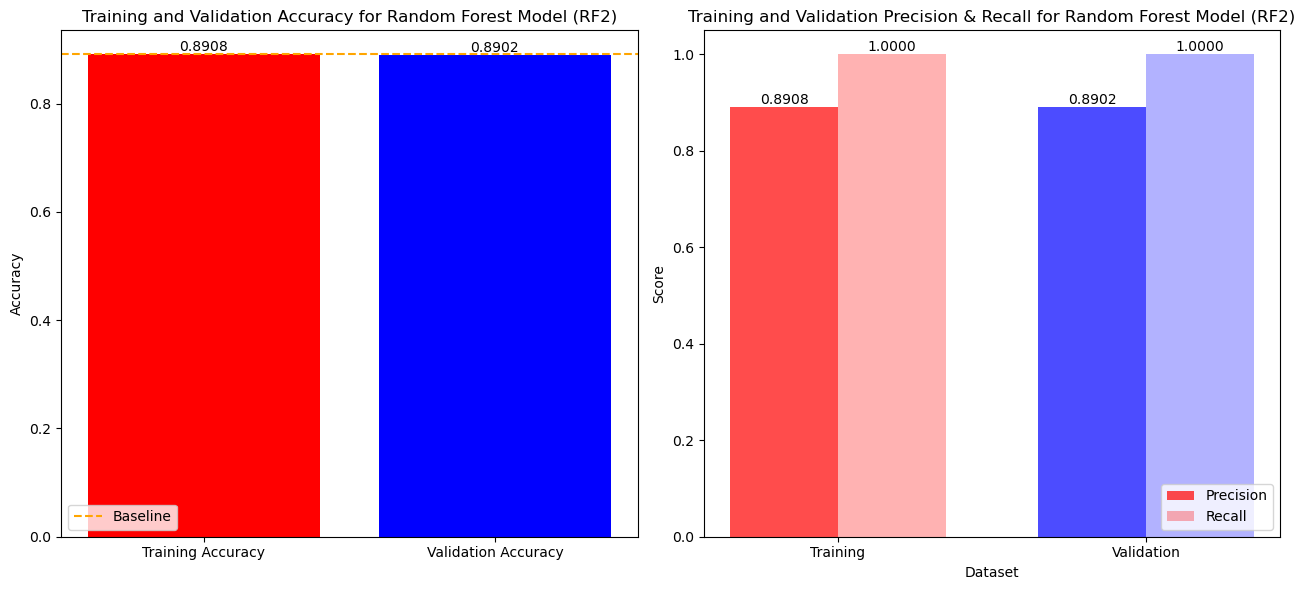

Training Accuracy: 0.8908
Validation Accuracy: 0.8902
Training Precision: 0.8908
Validation Precision: 0.8902
Training Recall: 1.0000
Validation Recall: 1.0000
Baseline Accuracy: 0.8910


In [130]:
# Generate predictions for the original training set (X_train) and validation set (X_val)
y_train_pred_rf2 = rf_model_2.predict(X_train_scaled_rf2)
y_val_pred_rf2 = rf_model_2.predict(X_val_scaled_rf2)

# Get accuracy for the original training set and validation set
train_accuracy_rf2 = accuracy_score(y_train_rf2, y_train_pred_rf2)
val_accuracy_rf2 = accuracy_score(y_val_rf2, y_val_pred_rf2)

# Compute precision, recall, f1-score for the original training and validation sets
train_precision_rf2, train_recall_rf2, _, _ = precision_recall_fscore_support(
    y_train_rf2, y_train_pred_rf2, average='binary', zero_division=0
)
val_precision_rf2, val_recall_rf2, _, _ = precision_recall_fscore_support(
    y_val_rf2, y_val_pred_rf2, average='binary', zero_division=0
)

# Prepare data for plotting
metrics_rf2 = {
    'Training Accuracy': train_accuracy_rf2,
    'Validation Accuracy': val_accuracy_rf2,
    'Training Precision': train_precision_rf2,
    'Validation Precision': val_precision_rf2,
    'Training Recall': train_recall_rf2,
    'Validation Recall': val_recall_rf2
}

# Create a figure for plotting
plt.figure(figsize=(13, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
bars = plt.bar(['Training Accuracy', 'Validation Accuracy'], 
        [metrics_rf2['Training Accuracy'], metrics_rf2['Validation Accuracy']], 
        color=['red', 'blue'])
plt.bar_label(bars, fmt='%.4f')
plt.title('Training and Validation Accuracy for Random Forest Model (RF2)')
plt.ylabel('Accuracy')

baseline_accuracy = percentages2_clean[1]/100
plt.axhline(y=baseline_accuracy, color='orange', linestyle='--', label='Baseline')
plt.legend()

# Plot Precision and Recall
plt.subplot(1, 2, 2)
x = np.arange(2)
width = 0.35
metrics_combined = [metrics_rf2['Training Precision'], metrics_rf2['Validation Precision']]
bars1 = plt.bar(x - width/2, metrics_combined, width, label='Precision', color=['red', 'blue'], alpha=0.7)
metrics_combined = [metrics_rf2['Training Recall'], metrics_rf2['Validation Recall']]
bars2 = plt.bar(x + width/2, metrics_combined, width, label='Recall', color=['red', 'blue'], alpha=0.3)
plt.xlabel('Dataset')
plt.ylabel('Score')
plt.title('Training and Validation Precision & Recall for Random Forest Model (RF2)')
plt.xticks(x, ['Training', 'Validation'])
plt.legend(loc=4)
plt.bar_label(bars1, fmt='%.4f')
plt.bar_label(bars2, fmt='%.4f')

plt.tight_layout()
plt.show()

# Print the metrics
print(f"Training Accuracy: {metrics_rf2['Training Accuracy']:.4f}")
print(f"Validation Accuracy: {metrics_rf2['Validation Accuracy']:.4f}")
print(f"Training Precision: {metrics_rf2['Training Precision']:.4f}")
print(f"Validation Precision: {metrics_rf2['Validation Precision']:.4f}")
print(f"Training Recall: {metrics_rf2['Training Recall']:.4f}")
print(f"Validation Recall: {metrics_rf2['Validation Recall']:.4f}")
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

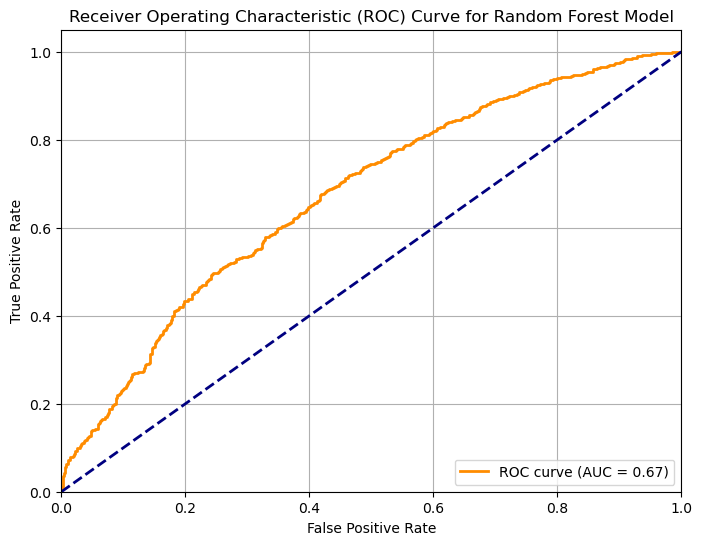

In [131]:
# Plot the ROC curve
plot_roc_curve(y_test_rf2, y_pred_proba_rf2, 'Receiver Operating Characteristic (ROC) Curve for Random Forest Model')

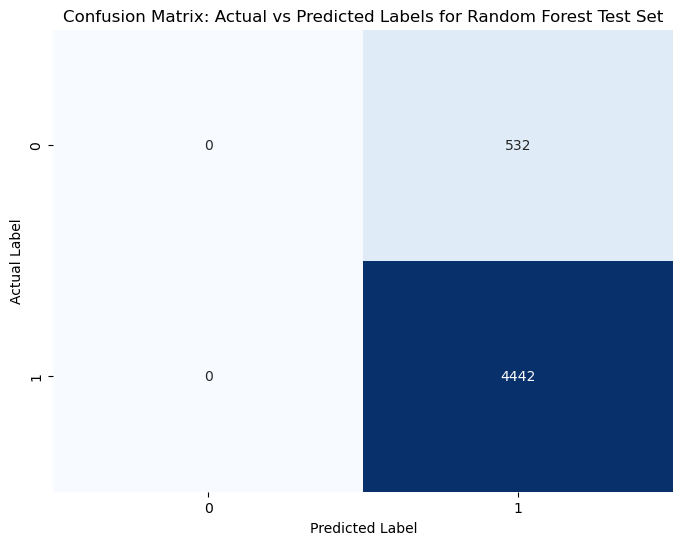

In [132]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf2, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix: Actual vs Predicted Labels for Random Forest Test Set')
plt.show()